##### $\hspace{15pt}$ **Filename: anomalyDetectionOnSyntheticData.ipynb**
##### $\hspace{1.5pt}$ **Date Created: January 17, 2024**
##### **Date Modified: January 27, 2024**
##### $\rule{6in}{1pt}$
##### **Run anomaly detection algorithms on synthetic data using [scikit-learn](https://scikit-learn.org/stable/modules/outlier_detection.html) and [pyod](https://pyod.readthedocs.io/en/latest/#).**
##### $\rule{6in}{1pt}$

##### Install `combo` and `pyod`.

In [1]:
!pip install combo -q pyod -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


##### Load modules and packages.

In [2]:
from pyod.models.abod import ABOD
from pyod.models.alad import ALAD
from pyod.models.anogan import AnoGAN
from pyod.models.cblof import CBLOF
from pyod.models.cd import CD
from pyod.models.cof import COF
from pyod.models.copod import COPOD
from pyod.models.deep_svdd import DeepSVDD
from pyod.models.dif import DIF
from pyod.models.ecod import ECOD
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.gmm import GMM
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.inne import INNE
from pyod.models.kde import KDE
from pyod.models.knn import KNN
from pyod.models.kpca import KPCA
from pyod.models.lmdd import LMDD
from pyod.models.loci import LOCI
from pyod.models.loda import LODA
from pyod.models.lof import LOF
from pyod.models.lscp import LSCP
from pyod.models.lunar import LUNAR
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.qmcd import QMCD
from pyod.models.rgraph import RGraph
from pyod.models.rod import ROD
from pyod.models.sampling import Sampling
from pyod.models.so_gaal import SO_GAAL
from pyod.models.sod import SOD
from pyod.models.sos import SOS
from pyod.utils.data import generate_data_clusters
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.datasets import make_blobs
from sklearn.ensemble import IsolationForest
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import make_pipeline
from sklearn.svm import OneClassSVM
import combo
import contextlib
import io
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import warnings

##### Suppress warnings.

In [3]:
warnings.filterwarnings("ignore")

##### Set pandas dataframes to display all the columns.

In [4]:
pd.set_option("display.max_columns", None)

##### Set the float format of pandas dataframes.

In [5]:
pd.options.display.float_format = "{:.3f}".format

##### Define a function for plotting the training and test sets.

In [6]:
def plotData(xTrain, yTrain, xTest, yTest, cmap):
    "Plot the training and test sets."

    datasets = [("Training Set", xTrain, yTrain), ("Test Set", xTest, yTest)]
    plt.rcParams['figure.figsize'] = [10, 4]
    fig, axs = plt.subplots(1, 2)

    for i, (datasetName, x, y) in enumerate(datasets):

        scatter = axs[i].scatter(x[:, 0], x[:, 1], s = 20, c = y, cmap = cmap, edgecolor = "k")

        if i == 0:
          handles, labels = scatter.legend_elements()

        axs[i].set_title(datasetName)
        axs[i].set_xticks(())
        axs[i].set_yticks(())

    if cmap == "viridis":
       labels = ["outliers", "inliers"]
    else:
       labels = ["inliers", "outliers"]

    axs[1].legend(handles = handles, labels = labels, title = "true class", loc = "lower left", bbox_to_anchor = (1.01, 0.79))

    fig.tight_layout()
    plt.show()

$\hspace{1in}$

##### **scikit-learn**

##### Create data for demonstration.

In [7]:
nSamples = 500
outliersFraction = 0.15
nOutliers = int(outliersFraction*nSamples)
nInliers = nSamples - nOutliers
inliers = make_blobs(n_samples = nInliers, centers = [[2, 2], [-2, -2]], cluster_std = [1.5, 0.5], random_state = 1)
rng = np.random.RandomState(1)
outliers = rng.uniform(low = -6, high = 6, size = (nOutliers, 2))

x = np.concatenate([inliers[0], outliers])
y = np.concatenate([np.ones(nInliers, dtype = int), -np.ones(nOutliers, dtype = int)])

data = pd.DataFrame(x, columns = ["x1", "x2"])
data["true class"] = y
data.head()

,x1,x2,true class
0,3.298,-1.452,1
1,2.063,2.874,1
2,2.286,5.150,1
3,2.935,1.348,1
4,-1.491,-1.385,1


##### Split the data into training and test sets.

In [8]:
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.3, random_state = 1, stratify = y)

In [9]:
trainSet = pd.DataFrame(xTrain, columns = ["x1", "x2"])
trainSet["true class"] = yTrain.astype(int)
trainSet.head()

,x1,x2,true class
0,-2.860,-1.971,1
1,-2.378,-1.074,1
2,5.278,-0.095,1
3,5.335,1.039,-1
4,4.600,1.484,-1


In [10]:
testSet = pd.DataFrame(xTest, columns = ["x1", "x2"])
testSet["true class"] = yTest.astype(int)
testSet.head()

,x1,x2,true class
0,-2.635,-1.859,1
1,-3.547,4.537,-1
2,5.495,0.398,-1
3,3.258,3.397,1
4,-5.465,-4.710,-1


##### Plot the training and test sets.

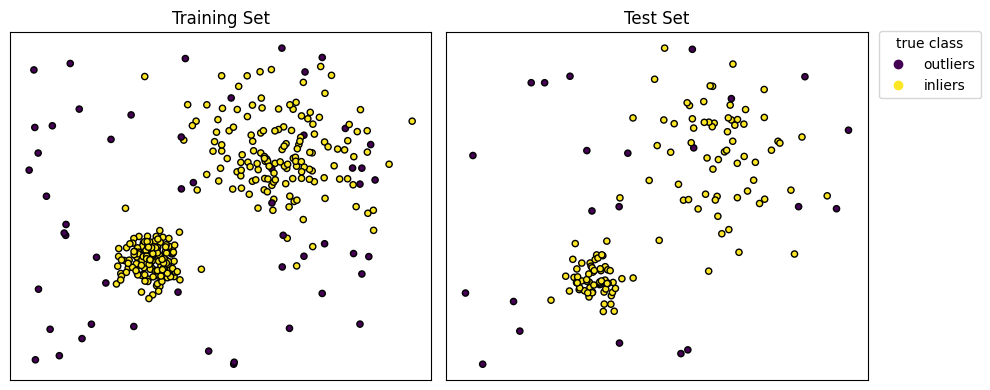

In [11]:
plotData(xTrain = xTrain, yTrain = yTrain, xTest = xTest, yTest = yTest, cmap = "viridis")

##### List the algorithms to be run on the data.

In [12]:
algorithms = [("DBSCAN", DBSCAN()),
              ("Elliptic Envelope", EllipticEnvelope(contamination = outliersFraction, random_state = 1)),
              ("Isolation Forest", IsolationForest(contamination = outliersFraction, random_state = 1)),
              ("Local Outlier Factor", LocalOutlierFactor(contamination = outliersFraction, novelty = True)),
              ("One-Class SVM", OneClassSVM(nu = outliersFraction)),
              ("One-Class SVM (SGD)", make_pipeline(Nystroem(random_state = 1), SGDOneClassSVM(nu = outliersFraction, random_state = 1)))]

##### Run each algorithm on each of the training and test sets and determine the anomaly score and prediction for each data point.

In [13]:
for algorithmName, algorithm in algorithms:

    algorithm.fit(xTrain)

    if algorithmName == "DBSCAN":

       trainSet["dbscan prediction"] = algorithm.fit_predict(xTrain)
       trainSet.loc[trainSet["dbscan prediction"] != -1, "dbscan prediction"] = 1

       testSet["dbscan prediction"] = algorithm.fit_predict(xTest)
       testSet.loc[testSet["dbscan prediction"] != -1, "dbscan prediction"] = 1

    elif algorithmName == "Local Outlier Factor":

       testSet[algorithmName.lower() + " score"] = algorithm.decision_function(xTest)
       testSet[algorithmName.lower() + " prediction"] = algorithm.predict(xTest)

    else:

       trainSet[algorithmName.lower() + " score"] = algorithm.decision_function(xTrain)
       trainSet[algorithmName.lower() + " prediction"] = algorithm.predict(xTrain)

       testSet[algorithmName.lower() + " score"] = algorithm.decision_function(xTest)
       testSet[algorithmName.lower() + " prediction"] = algorithm.predict(xTest)

In [14]:
trainSet.head()

,x1,x2,true class,dbscan prediction,elliptic envelope score,elliptic envelope prediction,isolation forest score,isolation forest prediction,one-class svm score,one-class svm prediction,one-class svm (sgd) score,one-class svm (sgd) prediction
0,-2.860,-1.971,1,1,4.879,1,0.106,1,0.361,1,0.024,1
1,-2.378,-1.074,1,1,5.027,1,0.099,1,0.249,1,0.024,1
2,5.278,-0.095,1,-1,-8.029,-1,-0.038,-1,-0.147,-1,0.017,1
3,5.335,1.039,-1,-1,-4.198,-1,-0.002,-1,-0.062,-1,0.021,1
4,4.600,1.484,-1,1,-0.166,-1,0.050,1,0.513,1,0.028,1


In [15]:
testSet.head()

,x1,x2,true class,dbscan prediction,elliptic envelope score,elliptic envelope prediction,isolation forest score,isolation forest prediction,local outlier factor score,local outlier factor prediction,one-class svm score,one-class svm prediction,one-class svm (sgd) score,one-class svm (sgd) prediction
0,-2.635,-1.859,1,1,5.099,1,0.130,1,0.271,1,0.330,1,0.027,1
1,-3.547,4.537,-1,-1,-21.451,-1,-0.115,-1,-0.251,-1,-1.070,-1,-0.061,-1
2,5.495,0.398,-1,-1,-7.179,-1,-0.039,-1,0.128,1,-0.297,-1,0.013,1
3,3.258,3.397,1,-1,3.873,1,0.068,1,0.335,1,0.886,1,0.016,1
4,-5.465,-4.710,-1,-1,1.216,1,-0.146,-1,-1.970,-1,-2.062,-1,0.012,1


##### The *DBSCAN* algorithm does not generate scores for the purpose of anomaly detection. The *Local Outlier Factor* algorithm does not also generate scores and predictions on the training set.

##### Display the decision boundary determined by each algorithm on the test set.

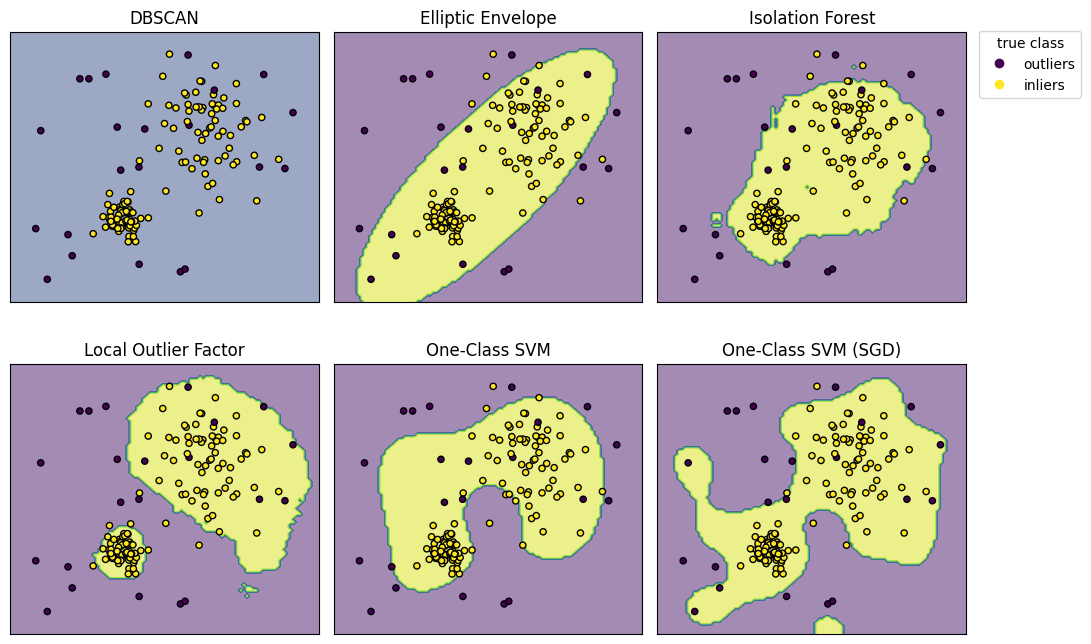

In [16]:
x0Min = xTest[:, 0].min()
x0Max = xTest[:, 0].max()
x1Min = xTest[:, 1].min()
x1Max = xTest[:, 1].max()
x0Length = x0Max - x0Min
x1Length = x1Max - x1Min
x0, x1 = np.meshgrid(np.linspace(start = x0Min - 0.1*x0Length, stop = x0Max + 0.1*x0Length, num = 100),
                         np.linspace(start = x1Min - 0.1*x1Length, stop = x1Max + 0.1*x1Length, num = 100))
grid = np.vstack([x0.ravel(), x1.ravel()]).T

plt.rcParams['figure.figsize'] = [11, 10]
fig, axs = plt.subplots(2, int(len(algorithms)/2))

i0 = tuple(range(2))
i1 = tuple(range(int(len(algorithms)/2)))
iProduct = list(itertools.product(i0, i1))

for i, (algorithmName, algorithm) in enumerate(algorithms):

    if algorithmName == "DBSCAN":

       predictions = algorithm.fit_predict(grid)
       predictions[predictions != -1] = 1

    else:
       predictions = algorithm.predict(grid)

    predictions = np.reshape(predictions, x0.shape)
    display = DecisionBoundaryDisplay(xx0 = x0, xx1 = x1, response = predictions)
    display.plot(ax = axs[iProduct[i][0], iProduct[i][1]], alpha = 0.5)
    scatter = display.ax_.scatter(xTest[:, 0], xTest[:, 1], c = yTest, s = 20, edgecolor = "k")
    axs[iProduct[i][0], iProduct[i][1]].set_title(algorithmName)
    axs[iProduct[i][0], iProduct[i][1]].set_aspect("equal", adjustable = "box")
    axs[iProduct[i][0], iProduct[i][1]].set_xticks(())
    axs[iProduct[i][0], iProduct[i][1]].set_yticks(())

    if i == 0:
       handles, labels = scatter.legend_elements()

axs[iProduct[2][0], iProduct[2][1]].legend(handles = handles, labels = ["outliers", "inliers"], title = "true class", loc = "lower left", bbox_to_anchor = (1.02, 0.73))

fig.tight_layout()
plt.subplots_adjust(bottom = 0.25)
plt.show()

##### Using the ground-truth labels and the generated scores, estimate the ROC AUC of each algorithm on the test set.

In [17]:
algorithmNames = []
rocAucScores = []

for algorithmName, _ in algorithms:

    if algorithmName != "DBSCAN":

       algorithmNames .append(algorithmName)
       rocAucScores.append(roc_auc_score(testSet["true class"].values, testSet[algorithmName.lower() + " score"].values))

rocAuc = pd.DataFrame({"algorithm": algorithmNames, "ROC AUC": rocAucScores})
rocAuc

,algorithm,ROC AUC
0,Elliptic Envelope,0.901
1,Isolation Forest,0.952
2,Local Outlier Factor,0.931
3,One-Class SVM,0.826
4,One-Class SVM (SGD),0.903


##### Note: The *DBSCAN* algorithm is not included in the table since, as mentioned earlier, the algorithm does not generate scores which are needed in the estimation of ROC AUC.

$\hspace{1in}$

##### **pyod**

##### Create training and test sets for demonstration.

In [18]:
nTrain = 300
nTest = 200
outliersFraction = 0.15
xTrain, xTest, yTrain, yTest = generate_data_clusters(n_train = nTrain, n_test = nTest, contamination = outliersFraction, density = "different",
                                                      dist = 0.15, random_state = 1)

In [19]:
trainSet = pd.DataFrame(xTrain, columns = ["x1", "x2"])
trainSet["true class"] = yTrain.astype(int)
trainSet.head()

,x1,x2,true class
0,1.797,0.900,1
1,-2.814,-0.709,0
2,-1.453,-3.496,1
3,-2.567,-1.182,0
4,0.370,1.221,1


In [20]:
testSet = pd.DataFrame(xTest, columns = ["x1", "x2"])
testSet["true class"] = yTest.astype(int)
testSet.head()

,x1,x2,true class
0,-2.242,-0.774,0
1,-2.622,-0.340,0
2,-2.142,-1.081,0
3,0.861,1.337,1
4,-2.840,-0.920,0


##### Plot the training and test sets.

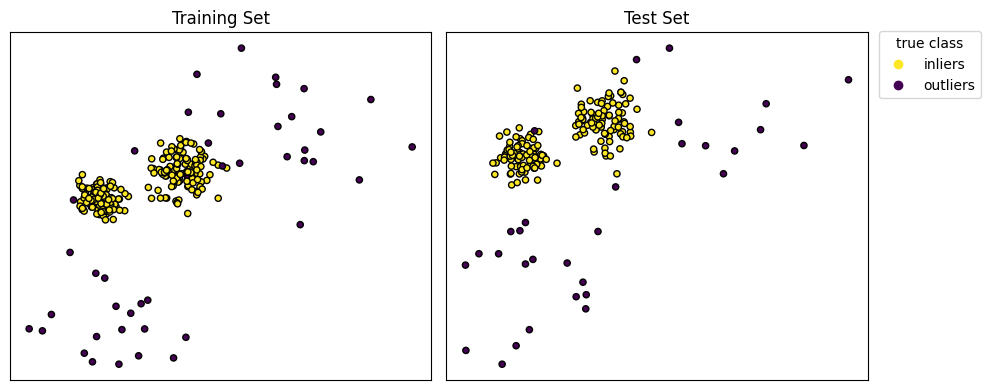

In [21]:
 plotData(xTrain = xTrain, yTrain = yTrain, xTest = xTest, yTest = yTest, cmap = "viridis_r")

##### List the algorithms to be run on the training and test sets.

In [22]:
algorithms = [("ABOD", ABOD(contamination = outliersFraction)),
              ("ALAD", ALAD(contamination = outliersFraction)),
              ("AnoGAN", AnoGAN(contamination = outliersFraction)),
              ("CBLOF", CBLOF(contamination = outliersFraction,
                              clustering_estimator = KMeans(n_init = 1, random_state = 1),
                              random_state = 1)),
              ("CD", CD(contamination = outliersFraction)),
              ("COF", COF(contamination = outliersFraction)),
              ("COPOD", COPOD(contamination = outliersFraction)),
              ("DeepSVDD", DeepSVDD(verbose = 0, random_state = 1, contamination = outliersFraction)),
              ("DIF", DIF(contamination = outliersFraction, random_state = 1)),
              ("ECOD", ECOD(contamination = outliersFraction)),
              ("FeatureBagging", FeatureBagging(contamination = outliersFraction, random_state = 1)),
              ("GMM", GMM(n_components = 2, random_state = 1, contamination = outliersFraction)),
              ("HBOS", HBOS(n_bins = "auto", contamination = outliersFraction)),
              ("IForest", IForest(contamination = outliersFraction, random_state = 1)),
              ("INNE", INNE(contamination = outliersFraction, random_state = 1)),
              ("KDE", KDE(contamination = outliersFraction)),
              ("KNN", KNN(contamination = outliersFraction)),
              ("KPCA", KPCA(contamination = outliersFraction, random_state = 1)),
              ("LMDD", LMDD(contamination = outliersFraction, random_state = 1)),
              ("LOCI", LOCI(contamination = outliersFraction)),
              ("LODA", LODA(contamination = outliersFraction, n_bins = "auto")),
              ("LOF", LOF(contamination = outliersFraction)),
              ("LSCP", LSCP(detector_list = [LOF(n_neighbors = 10, contamination = outliersFraction),
                                             LOF(n_neighbors = 20, contamination = outliersFraction),
                                             LOF(n_neighbors = 30, contamination = outliersFraction)],
                            n_bins = 3, random_state = 1, contamination = outliersFraction)),
              ("LUNAR", LUNAR(contamination = outliersFraction)),
              ("MCD", MCD(contamination = outliersFraction, random_state = 1)),
              ("OCSVM", OCSVM(contamination = outliersFraction)),
              ("PCA", PCA(contamination = outliersFraction, random_state = 1)),
              ("QMCD", QMCD(contamination = outliersFraction)),
              ("RGraph", RGraph(contamination = outliersFraction, verbose = 0)),
              ("ROD", ROD(contamination = outliersFraction)),
              ("Sampling", Sampling(contamination = outliersFraction, random_state = 1)),
              ("SO_GAAL", SO_GAAL(contamination = outliersFraction)),
              ("SOD", SOD(contamination = outliersFraction)),
              ("SOS", SOS(contamination = outliersFraction))]

##### Run each algorithm on each of the training and test sets and determine the anomaly score and prediction for each data point.

In [23]:
startTimeAll = time.time()

for algorithmName, algorithm in algorithms:

    startTimeAlgorithm = time.time()
    print("\n Running %s ..." % algorithmName, end = " ")

    if algorithmName in ["DeepSVDD", "SO_GAAL"]:

       print("\n\n", end = " ")
       additionalString = "\n          ... "

       with contextlib.redirect_stdout(io.StringIO()):
           algorithm.fit(xTrain)

    else:

       additionalString = ""
       algorithm.fit(xTrain)

    trainSet[algorithmName.lower() + " score"] = algorithm.decision_scores_
    trainSet[algorithmName.lower() + " prediction"] = algorithm.labels_

    testSet[algorithmName.lower() + " score"] = algorithm.decision_function(xTest)
    testSet[algorithmName.lower() + " prediction"] = algorithm.predict(xTest)

    executionTimeAlgorithm = time.time() - startTimeAlgorithm

    if executionTimeAlgorithm < 60:
      print(additionalString + "Completed in %.2f seconds." % executionTimeAlgorithm)
    else:
      print(additionalString + "Completed in %.2f minutes." % (executionTimeAlgorithm/60))

executionTimeAll = time.time() - startTimeAll

if executionTimeAll < 60:
  print("\n Overall Execution Time = %.2f seconds" % executionTimeAll)
else:
  print("\n Overall Execution Time = %.2f minutes" % (executionTimeAll/60))


 Running ABOD ... Completed in 3.13 seconds.

 Running ALAD ... Completed in 1.78 minutes.

 Running AnoGAN ... Completed in 8.16 minutes.

 Running CBLOF ... Completed in 2.41 seconds.

 Running CD ... Completed in 0.03 seconds.

 Running COF ... Completed in 0.12 seconds.

 Running COPOD ... Completed in 0.16 seconds.

 Running DeepSVDD ... 

7/7 [==============================] - 0s 2ms/step

          ... Completed in 5.17 seconds.

 Running DIF ... Completed in 6.77 seconds.

 Running ECOD ... Completed in 0.01 seconds.

 Running FeatureBagging ... Completed in 0.25 seconds.

 Running GMM ... Completed in 0.13 seconds.

 Running HBOS ... Completed in 0.08 seconds.

 Running IForest ... Completed in 0.79 seconds.

 Running INNE ... Completed in 0.56 seconds.

 Running KDE ... Completed in 0.06 seconds.

 Running KNN ... Completed in 0.06 seconds.

 Running KPCA ... Completed in 0.37 seconds.

 Running LMDD ... Completed in 2.38 seconds.

 Running LOCI ... Completed in 52.13 second

In [24]:
trainSet.head()

,x1,x2,true class,abod score,abod prediction,alad score,alad prediction,anogan score,anogan prediction,cblof score,cblof prediction,cd score,cd prediction,cof score,cof prediction,copod score,copod prediction,deepsvdd score,deepsvdd prediction,dif score,dif prediction,ecod score,ecod prediction,featurebagging score,featurebagging prediction,gmm score,gmm prediction,hbos score,hbos prediction,iforest score,iforest prediction,inne score,inne prediction,kde score,kde prediction,knn score,knn prediction,kpca score,kpca prediction,lmdd score,lmdd prediction,loci score,loci prediction,loda score,loda prediction,lof score,lof prediction,lscp score,lscp prediction,lunar score,lunar prediction,mcd score,mcd prediction,ocsvm score,ocsvm prediction,pca score,pca prediction,qmcd score,qmcd prediction,rgraph score,rgraph prediction,rod score,rod prediction,sampling score,sampling prediction,so_gaal score,so_gaal prediction,sod score,sod prediction,sos score,sos prediction
0,1.797,0.900,1,-0.862,1,0.088,0,2.704,1,2.299,1,0.007,0,1.419,1,4.935,1,0.053,0,0.405,1,6.620,1,2.514,1,5.214,1,6.242,1,0.117,1,0.953,1,4.944,1,1.078,1,-0.000,0,71.327,0,0.087,0,0.017,0,2.623,1,0.485,1,1.008,1,9.857,1,38.625,1,13.212,1,0.757,1,-0.000,0,85.091,1,1.078,1,0.034,0,0.083,0,0.306,0
1,-2.814,-0.709,0,-376371.168,0,0.093,0,0.991,0,0.119,0,0.011,0,0.965,0,1.883,0,0.000,0,0.384,0,2.850,0,1.032,0,1.828,0,2.742,0,-0.081,0,0.443,0,2.662,0,0.087,0,0.000,0,116.479,0,0.071,0,0.022,0,1.037,0,-0.448,0,-0.429,0,1.934,0,0.014,0,9.855,0,0.038,0,-0.000,0,0.353,0,0.221,0,0.845,0,0.019,0,0.184,0
2,-1.453,-3.496,1,-7.658,1,0.207,1,2.053,1,0.610,0,0.137,1,1.267,0,3.621,1,0.038,0,0.481,1,3.631,0,2.439,1,5.457,1,4.738,1,0.116,1,0.940,1,5.113,1,0.987,1,-0.000,0,143.302,1,3.026,1,0.021,0,3.039,1,2.370,1,1.862,1,105.980,1,40.515,1,12.587,1,0.632,1,-0.000,0,38.032,1,0.733,1,0.979,1,0.000,0,0.372,0
3,-2.567,-1.182,0,-77042.754,0,0.108,0,1.123,0,0.141,0,0.001,0,1.024,0,2.717,0,0.027,0,0.294,0,3.136,0,1.032,0,1.775,0,4.478,0,-0.085,0,0.497,0,2.639,0,0.105,0,0.000,0,42.856,0,-0.008,0,0.014,0,1.014,0,-0.487,0,-0.348,0,1.720,0,-0.674,0,8.757,0,0.081,0,-0.000,0,0.050,0,0.143,0,0.849,0,0.001,0,0.302,0
4,0.370,1.221,1,-0.048,1,0.052,0,2.188,1,1.525,1,0.001,0,2.434,1,4.583,1,0.007,0,0.372,0,6.384,1,2.900,1,5.869,1,6.242,1,0.113,1,0.947,1,3.944,1,1.051,1,-0.000,0,66.443,0,3.007,1,0.017,0,2.767,1,1.521,1,1.565,1,16.459,1,28.181,1,11.951,1,0.617,1,-0.000,0,30.111,1,1.049,1,0.076,0,0.452,1,0.715,1


In [25]:
testSet.head()

,x1,x2,true class,abod score,abod prediction,alad score,alad prediction,anogan score,anogan prediction,cblof score,cblof prediction,cd score,cd prediction,cof score,cof prediction,copod score,copod prediction,deepsvdd score,deepsvdd prediction,dif score,dif prediction,ecod score,ecod prediction,featurebagging score,featurebagging prediction,gmm score,gmm prediction,hbos score,hbos prediction,iforest score,iforest prediction,inne score,inne prediction,kde score,kde prediction,knn score,knn prediction,kpca score,kpca prediction,lmdd score,lmdd prediction,loci score,loci prediction,loda score,loda prediction,lof score,lof prediction,lscp score,lscp prediction,lunar score,lunar prediction,mcd score,mcd prediction,ocsvm score,ocsvm prediction,pca score,pca prediction,qmcd score,qmcd prediction,rgraph score,rgraph prediction,rod score,rod prediction,sampling score,sampling prediction,so_gaal score,so_gaal prediction,sod score,sod prediction,sos score,sos prediction
0,-2.242,-0.774,0,-638.406,0,0.072,0,0.686,0,0.390,0,0.003,0,1.032,0,1.531,0,0.066,0,0.184,0,1.669,0,1.246,0,1.114,0,2.742,0,-0.059,0,0.656,0,2.573,0,0.179,0,0.000,1,14.040,0,-0.010,0,0.022,0,1.294,0,-0.139,0,-0.116,0,0.297,0,-1.960,0,7.831,0,0.002,0,-0.000,0,0.018,0,0.254,0,0.814,0,0.034,0,0.206,0
1,-2.622,-0.340,0,-112.312,0,0.067,0,0.928,0,0.516,0,0.016,1,1.409,1,1.591,0,0.003,0,0.213,0,2.492,0,1.239,0,2.818,0,2.742,0,-0.040,0,0.787,0,2.724,0,0.238,0,0.000,1,72.385,0,0.059,0,0.022,0,1.418,0,0.303,0,-0.082,0,4.540,0,3.988,0,9.722,0,0.054,0,-0.000,0,0.917,0,0.507,0,0.826,0,0.221,1,0.895,1
2,-2.142,-1.081,0,-1058.929,0,0.086,0,0.837,0,0.308,0,0.002,0,0.932,0,2.305,0,0.108,0,0.206,0,2.404,0,1.281,0,1.641,0,2.742,0,-0.063,0,0.638,0,2.613,0,0.144,0,0.000,1,68.565,0,-0.013,0,0.022,0,1.352,0,-0.071,0,-0.197,0,1.604,0,-0.218,0,7.282,0,0.064,0,-0.000,0,0.066,0,0.411,0,0.825,0,0.064,0,0.223,0
3,0.861,1.337,1,-0.997,1,0.077,0,2.517,1,1.870,1,0.014,1,2.177,1,5.136,1,0.031,0,0.264,0,7.264,1,2.907,1,5.797,1,6.242,1,0.133,1,0.948,1,4.449,1,1.194,1,0.001,1,180.585,1,3.024,1,0.017,0,2.542,1,1.568,1,1.239,1,16.776,1,34.848,1,13.117,1,0.922,1,-0.000,0,50.796,1,1.444,1,0.039,0,1.046,1,0.958,1
4,-2.840,-0.920,0,-206364.443,0,0.104,0,1.104,0,0.104,0,0.011,0,0.918,0,2.306,0,0.001,0,0.186,0,3.384,0,0.997,0,1.572,0,2.742,0,-0.091,0,0.380,0,2.657,0,0.059,0,0.000,0,75.262,0,0.341,0,0.022,0,0.981,0,-0.499,0,-0.452,0,1.203,0,-0.678,0,9.788,0,0.094,0,-0.000,0,0.101,0,0.113,0,0.851,0,0.017,0,0.133,0


##### Display the decision boundary determined by each algorithm on the test set.


 Rendering using ABOD ... Completed in 3.76 seconds.

 Rendering using ALAD ... Completed in 0.08 seconds.

 Rendering using AnoGAN ... Completed in 6.82 minutes.

 Rendering using CBLOF ... Completed in 0.04 seconds.

 Rendering using CD ... Completed in 0.03 seconds.

 Rendering using COF ... Completed in 22.20 seconds.

 Rendering using COPOD ... Completed in 0.03 seconds.

 Rendering using DeepSVDD ... 

313/313 [==============================] - 0s 1ms/step

          ... Completed in 0.73 seconds.

 Rendering using DIF ... Completed in 23.29 seconds.

 Rendering using ECOD ... Completed in 0.02 seconds.

 Rendering using FeatureBagging ... Completed in 0.25 seconds.

 Rendering using GMM ... Completed in 0.01 seconds.

 Rendering using IForest ... Completed in 0.16 seconds.

 Rendering using INNE ... Completed in 0.35 seconds.

 Rendering using KDE ... Completed in 0.22 seconds.

 Rendering using KNN ... Completed in 0.81 seconds.

 Rendering using KPCA ... Completed in 2.86 sec

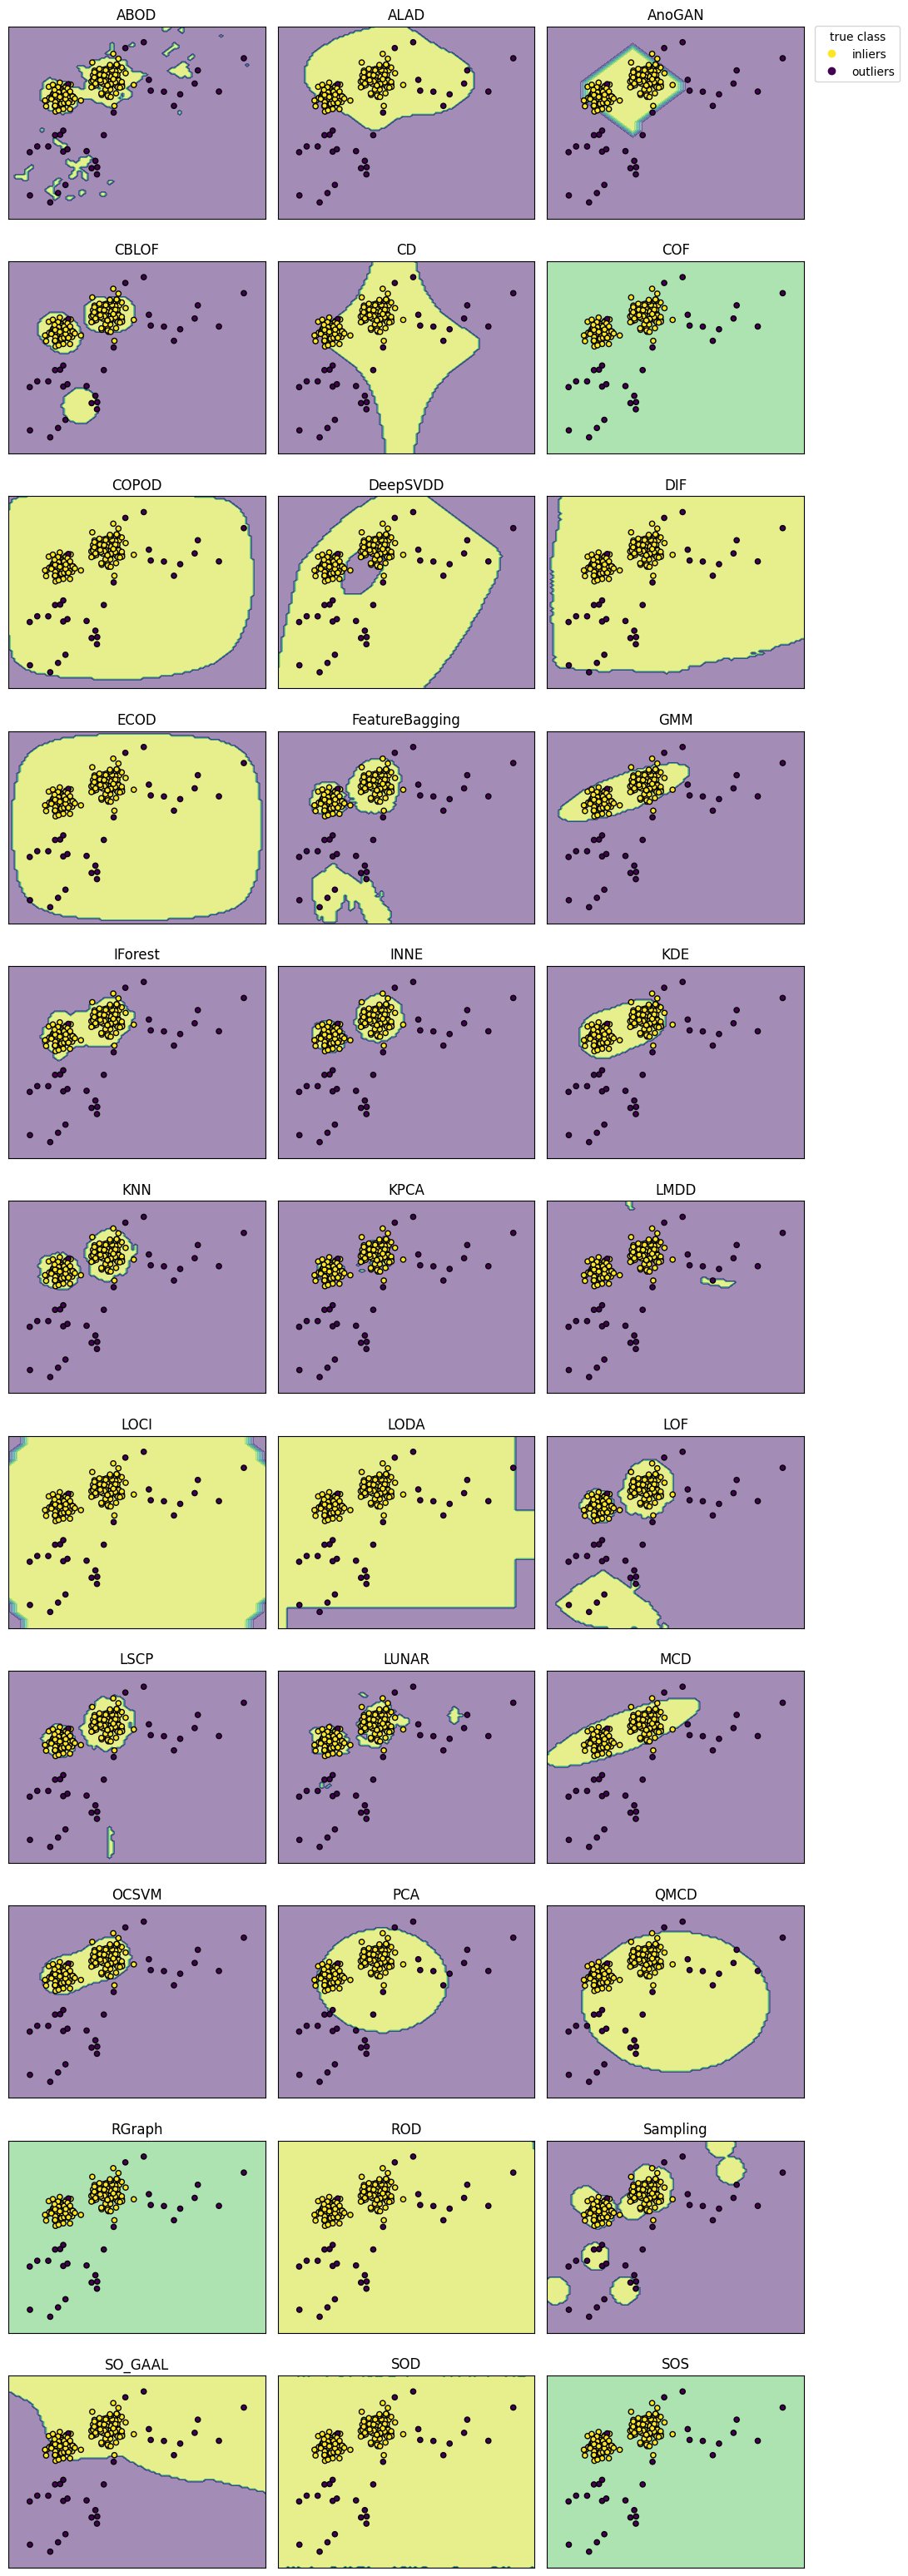

In [26]:
startTimeAll = time.time()

algorithmsToExclude = ["HBOS"]
filteredAlgorithms = [(name, algorithm) for name, algorithm in algorithms if name not in algorithmsToExclude]

x0Min = xTest[:, 0].min()
x0Max = xTest[:, 0].max()
x1Min = xTest[:, 1].min()
x1Max = xTest[:, 1].max()
x0Length = x0Max - x0Min
x1Length = x1Max - x1Min

plt.rcParams['figure.figsize'] = [11, 45]
fig, axs = plt.subplots(11, int(np.ceil(len(filteredAlgorithms)/11)))

i0 = tuple(range(11))
i1 = tuple(range(int(np.ceil(len(filteredAlgorithms)/11))))
iProduct = list(itertools.product(i0, i1))
n = min(len(filteredAlgorithms), len(iProduct))

for i, (algorithmName, algorithm) in enumerate(filteredAlgorithms):

    startTimeAlgorithm = time.time()
    print("\n Rendering using %s ..." % algorithmName, end = " ")

    if algorithmName in ["DeepSVDD", "SO_GAAL"]:

       print("\n\n", end = " ")
       additionalString = "\n          ... "

    else:
       additionalString = ""

    if algorithmName in ["AnoGAN", "LOCI"]:
       nSamples = 25
    else:
       nSamples = 100

    x0, x1 = np.meshgrid(np.linspace(start = x0Min - 0.1*x0Length, stop = x0Max + 0.1*x0Length, num = nSamples),
                         np.linspace(start = x1Min - 0.1*x1Length, stop = x1Max + 0.1*x1Length, num = nSamples))
    grid = np.vstack([x0.ravel(), x1.ravel()]).T
    predictions = algorithm.predict(grid)
    predictions = np.reshape(predictions, x0.shape)

    display = DecisionBoundaryDisplay(xx0 = x0, xx1 = x1, response = predictions)
    display.plot(ax = axs[iProduct[i][0], iProduct[i][1]], alpha = 0.5, cmap = "viridis_r")
    scatter = display.ax_.scatter(xTest[:, 0], xTest[:, 1], c = yTest, s = 20, cmap = "viridis_r", edgecolor = "k")
    axs[iProduct[i][0], iProduct[i][1]].set_title(algorithmName)
    axs[iProduct[i][0], iProduct[i][1]].set_aspect("equal", adjustable = "box")
    axs[iProduct[i][0], iProduct[i][1]].set_xticks(())
    axs[iProduct[i][0], iProduct[i][1]].set_yticks(())

    executionTimeAlgorithm = time.time() - startTimeAlgorithm

    if executionTimeAlgorithm < 60:
      print(additionalString + "Completed in %.2f seconds." % executionTimeAlgorithm)
    else:
      print(additionalString + "Completed in %.2f minutes." % (executionTimeAlgorithm/60))

    if i == 0:
       handles, labels = scatter.legend_elements()

axs[iProduct[2][0], iProduct[2][1]].legend(handles = handles, labels = ["inliers", "outliers"], title = "true class", loc = "lower left", bbox_to_anchor = (1.02, 0.68))

if len(filteredAlgorithms) < len(iProduct):

   for i in range(len(filteredAlgorithms), len(iProduct)):
       fig.delaxes(axs[iProduct[i][0]][iProduct[i][1]])

executionTimeAll = time.time() - startTimeAll

if executionTimeAll < 60:
  print("\n Overall Execution Time = %.2f seconds \n" % executionTimeAll)
else:
  print("\n Overall Execution Time = %.2f minutes \n" % (executionTimeAll/60))

fig.tight_layout()
plt.subplots_adjust(bottom = 0.3)
plt.show()

##### Note: The *HBOS* algorithm is excluded in the generation of the decision boundary visualization. An error occurs when the algorithm is making predictions on the grid that are needed in the rendering of the visualization.

##### Using the ground-truth labels and the generated scores, estimate the ROC AUC of each algorithm on the test set.

In [27]:
algorithmNames = []
rocAucScores = []

for algorithmName, _ in algorithms:

       algorithmNames.append(algorithmName)
       rocAucScores.append(roc_auc_score(testSet["true class"].values, testSet[algorithmName.lower() + " score"].values))

rocAuc = pd.DataFrame({"algorithm": algorithmNames, "ROC AUC": rocAucScores})
rocAuc

,algorithm,ROC AUC
0,ABOD,0.991
1,ALAD,0.845
2,AnoGAN,0.976
3,CBLOF,0.987
4,CD,0.947
5,COF,0.967
6,COPOD,0.957
7,DeepSVDD,0.321
8,DIF,0.994
9,ECOD,0.907
